In [6]:
from library import *
from dataset_creation import *

# K-Neighbour

## Find the best K

In [20]:
#https://medium.com/@mohtedibf/in-depth-parameter-tuning-for-knn-4c0de485baf6
def validation_curve_KN(X, y):
    skf = StratifiedKFold(n_splits=5, random_state = 123, shuffle=True)

    train_results = []
    test_results = []

    for k in tqdm(range(1,20,2)):

        train_score = []
        test_score = []
        for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
            X_train = X[train_index]
            y_train = y[train_index]  # Based on your code, you might need a ravel call here, but I would look into how you're generating your y
            X_test = X[test_index]
            y_test = y[test_index]  # See comment on ravel and  y_train

            model = KNeighborsClassifier(n_neighbors = k) # Choose a model here
            model.fit(X_train, y_train )

            train_pred = model.predict(X_train)
            train_score.append(accuracy_score(y_train, train_pred))
            y_pred = model.predict(X_test)
            test_score.append(accuracy_score(y_test, y_pred))

        train_results.append(np.mean(np.array(train_score)))
        test_results.append(np.mean(np.array(test_score)))
        
    return train_results, test_results

In [29]:
def plot_validation_curve(train_results, test_results, y_ax, name, xlable="n_neighbors"):
    fig, ax = plt.subplots(1,1, figsize=(15,10), facecolor="k")

   

    line1, = plt.plot(y_ax, train_results, 'o-', label='Train Accuracy', color="lightgray")
    line2, = plt.plot(y_ax, test_results, 'o-', label='Test Accuracy', color="gold")
    ax.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    ax.set_ylabel('accuracy', color="w", size=25, labelpad=10)
    ax.set_xlabel(xlable, color="w", size=25, labelpad=10)

    ax.spines['bottom'].set_color('w')
    ax.spines['left'].set_color('w')

    ax.tick_params(axis='x', colors='w')
    ax.tick_params(axis='y', colors='w')

    plt.xticks(size = 20)
    plt.yticks(size = 20)

    ax.grid(color="lightgray", alpha = 0.2)
    ax.legend(loc="lower right", facecolor="w")
    plt.savefig("report/"+name, bbox_inches='tight')

100%|███████████████████████████████████████████| 10/10 [00:49<00:00,  4.94s/it]


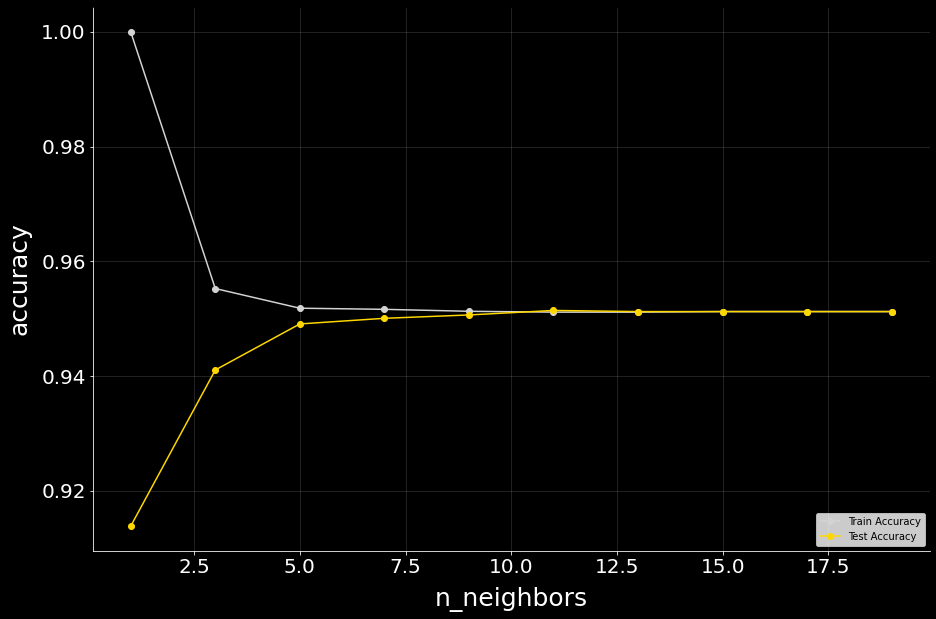

In [21]:
train_results, test_results = validation_curve_KN(X_big_array, y.array)

plot_validation_curve(train_results, test_results, list(range(1,20,2)), "validation_curve_not_sampled.png")

100%|███████████████████████████████████████████| 10/10 [02:29<00:00, 14.95s/it]


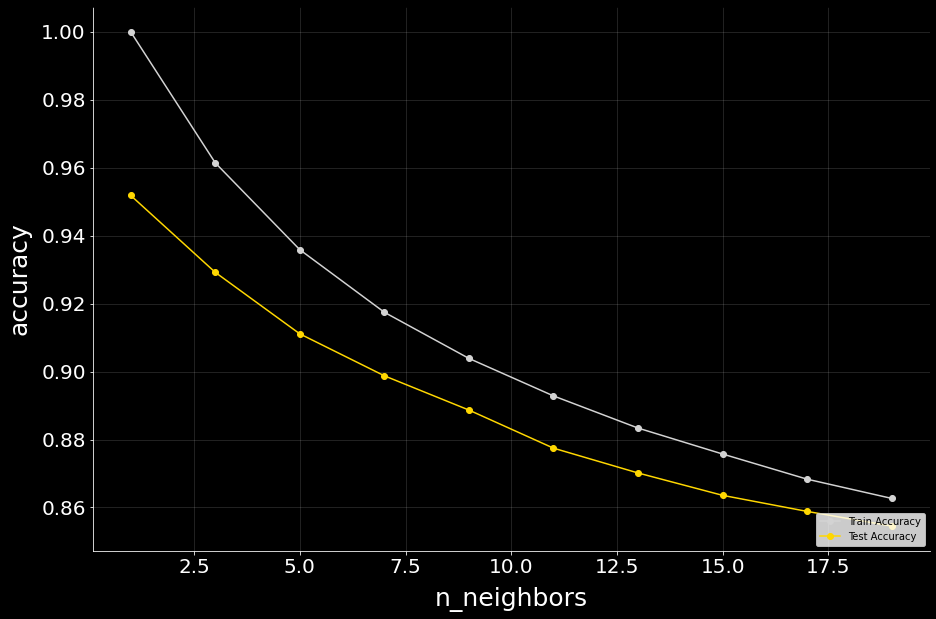

In [22]:
train_results, test_results = validation_curve_KN(X_res, y_res)
plot_validation_curve(train_results, test_results, list(range(1,20,2)), "validation_curve_sampled.png")

In [13]:
accuracies = []

for k in tqdm(range(1,100,10)):

    kfold = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

    model = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)

    #sfs_kn = SFS(estimator = model, k_features=(3,17), cv=kfold, n_jobs=-1)

    #sfs_kn.fit(X_train, y_train)

    #temp_X = sfs_kn.transform(X_train)

    scores = cross_validate(model, X_big_array, y.array, scoring='roc_auc', cv=kfold, n_jobs=-1, return_train_score=True)    

    accuracies.append((np.mean(scores["test_score"]), np.mean(scores["train_score"])))
        
        

100%|███████████████████████████████████████████| 10/10 [00:47<00:00,  4.79s/it]


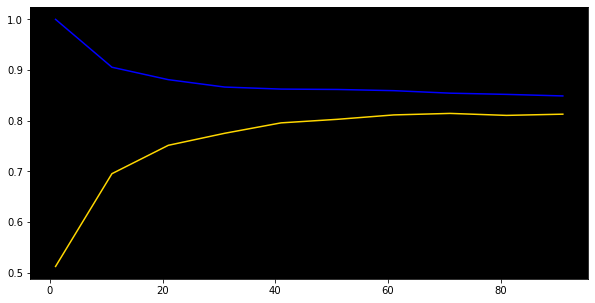

In [15]:
plt.figure(figsize=(10,5))
plt.plot(range(1,100,10), [el[0] for el in accuracies], color="gold")
plt.plot(range(1,100,10), [el[1] for el in accuracies], color = "blue")

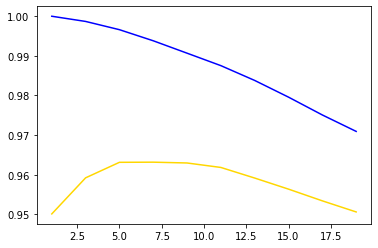

In [9]:
plt.plot(range(1,20,2), [el[0] for el in accuracies], color="gold")
plt.plot(range(1,20,2), [el[1] for el in accuracies], color = "blue")

In [6]:
#plot_line([el[0] for el in accuracies],[el[1] for el in accuracies], "k-neighbour", "Accuracy")

In [7]:
INserire valutation curve

SyntaxError: invalid syntax (1224367840.py, line 1)

## Apply the model with the best parameters and plot ROC curve

In [73]:
def roc_curve_kn(X, y, k, name):
    #Calcolo la roc curve

    kfold = KFold(n_splits=5, random_state=123, shuffle=True)

    fig, ax = plt.subplots(1,1,figsize=(20,10), facecolor="k")
    
    plt.rcParams['axes.facecolor'] = 'k'
   

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,100)
    i = 1
    for train_index, test_index in kfold.split(X, y):

        model = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)

        out = model.predict(X_test)

        fpr, tpr, t = roc_curve(y_test, out)

        tprs.append(np.interp(mean_fpr, fpr, tpr))

        roc_auc = auc(fpr, tpr)

        aucs.append(roc_auc)

        ax.plot(fpr, tpr, lw=2, color="w", alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i= i+1

    ax.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'w')
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    ax.plot(mean_fpr, mean_tpr, color='gold',
             label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=4, alpha=1)

    ax.set_xlabel('False Positive Rate',color="w", size=25, labelpad=10)
    ax.set_ylabel('True Positive Rate', color="w", size=25, labelpad=10)
    ax.set_title('ROC')

    ax.text(0.32,0.7,'More accurate area',fontsize = 12)
    ax.text(0.63,0.4,'Less accurate area',fontsize = 12)


    ax.spines['bottom'].set_color('w')
    ax.spines['left'].set_color('w')

    ax.tick_params(axis='x', colors='w')
    ax.tick_params(axis='y', colors='w')

    plt.xticks(size = 20)
    plt.yticks(size = 20)

    ax.grid(color="lightgray", alpha = 0.2)
    ax.legend(loc="lower right", facecolor="w")
    
    plt.savefig("report/"+name, bbox_inches='tight')
    
    return mean_fpr, mean_tpr

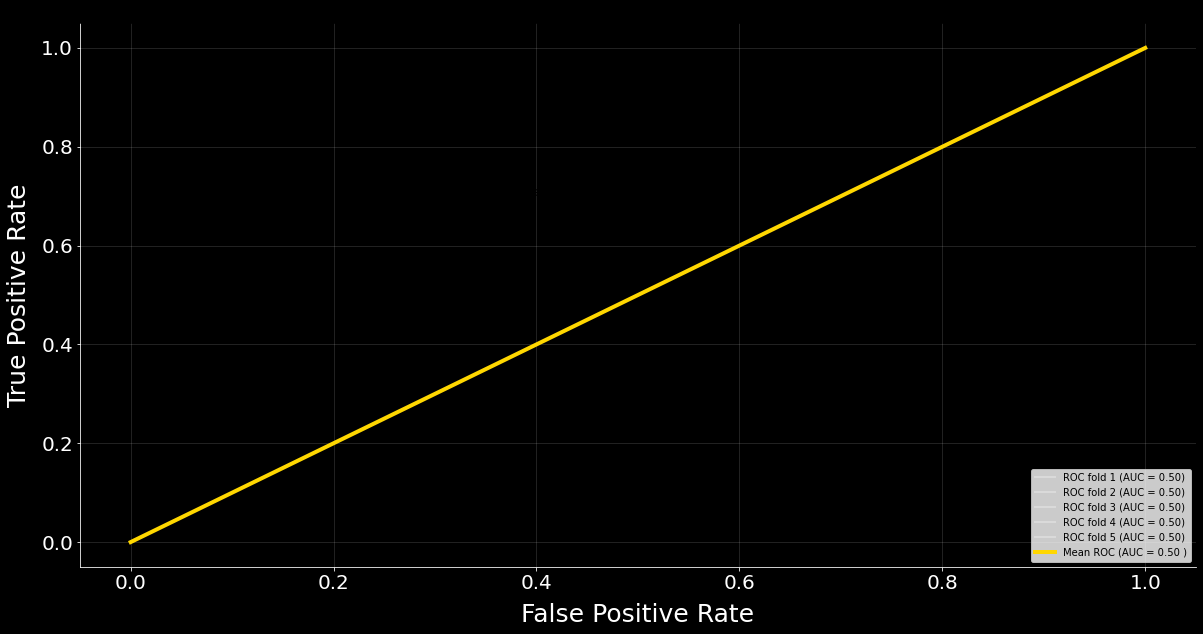

In [74]:
fpr1, tpr1 = roc_curve_kn(X_big_array, y.array, 15, "roc_curve_kn_not_sampled.png")

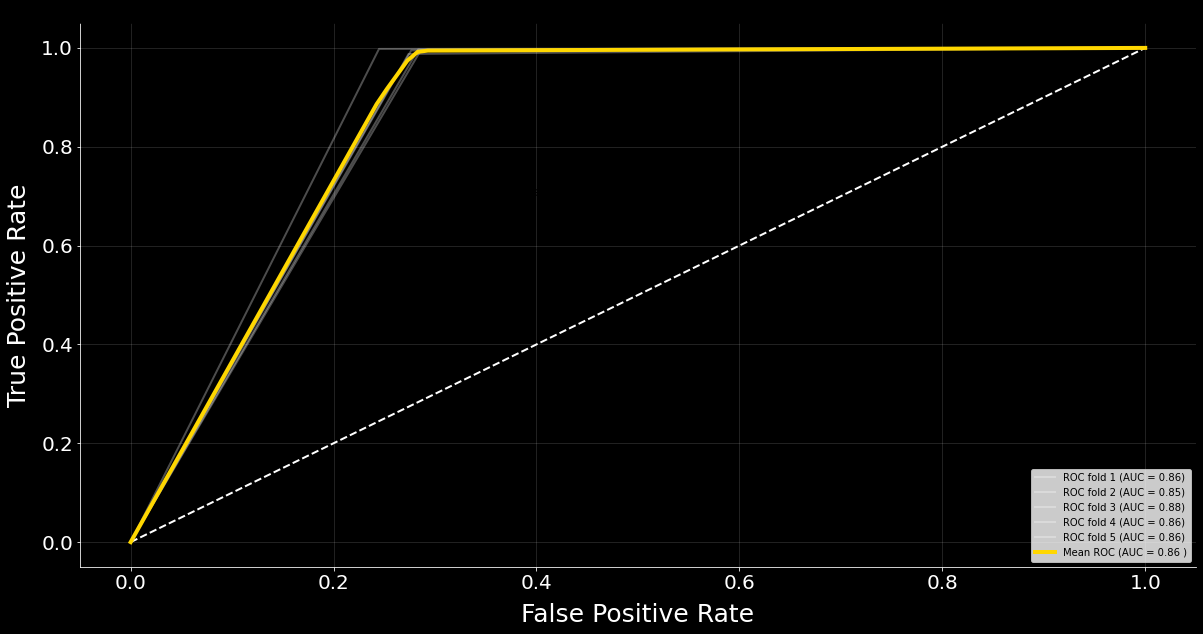

In [75]:
fpr2, tpr2 = roc_curve_kn(X_res, y_res, 15, "roc_curve_kn_sampled.png")

# Logistic Regression

## Find the best degree

In [46]:
def validation_curve_logreg(X, y, degree):
    skf = StratifiedKFold(n_splits=5, random_state = 123, shuffle=True)

    train_results = []
    test_results = []

    for deg in tqdm(range(1,degree+1)):

        train_score = []
        test_score = []
        
        poly = PolynomialFeatures(degree = deg, interaction_only=False, include_bias=False)
        
        X_poly = poly.fit_transform(X)
        
        for fold, (train_index, test_index) in enumerate(skf.split(X_poly, y), 1):
            X_train = X_poly[train_index]
            y_train = y[train_index]  # Based on your code, you might need a ravel call here, but I would look into how you're generating your y
            X_test = X_poly[test_index]
            y_test = y[test_index]  # See comment on ravel and  y_train

            model = LogisticRegression(solver="newton-cg", n_jobs=-1) # Choose a model here
            model.fit(X_train, y_train )

            train_pred = model.predict(X_train)
            train_score.append(accuracy_score(y_train, train_pred))
            y_pred = model.predict(X_test)
            test_score.append(accuracy_score(y_test, y_pred))

        train_results.append(np.mean(np.array(train_score)))
        test_results.append(np.mean(np.array(test_score)))
        
    return train_results, test_results

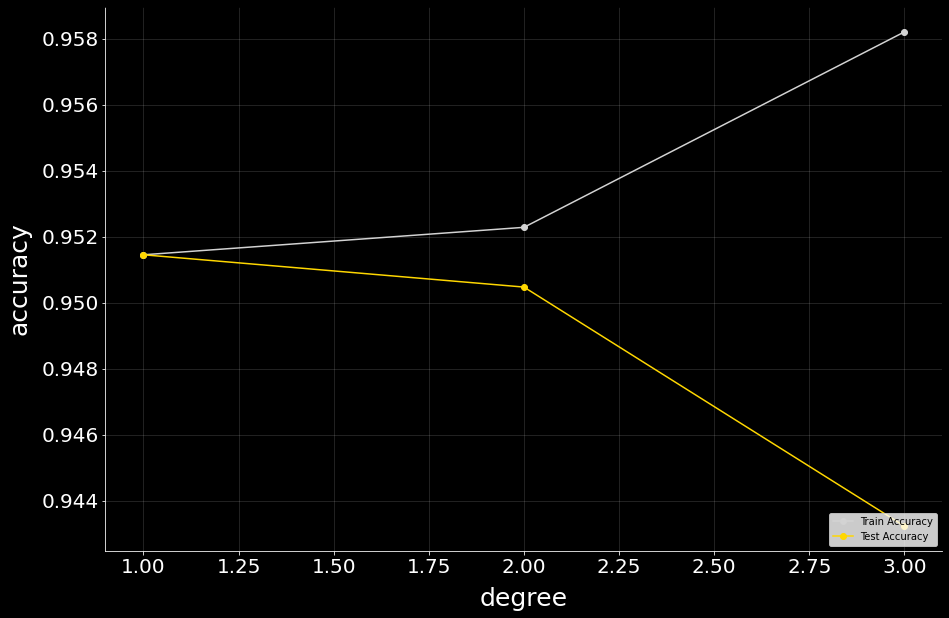

In [48]:
train_results, test_results = validation_curve_logreg(X_big_array, y.array, 3)
plot_validation_curve(train_results, test_results, [1,2,3], "validation_curve_logreg_not_sampled.png", "degree")

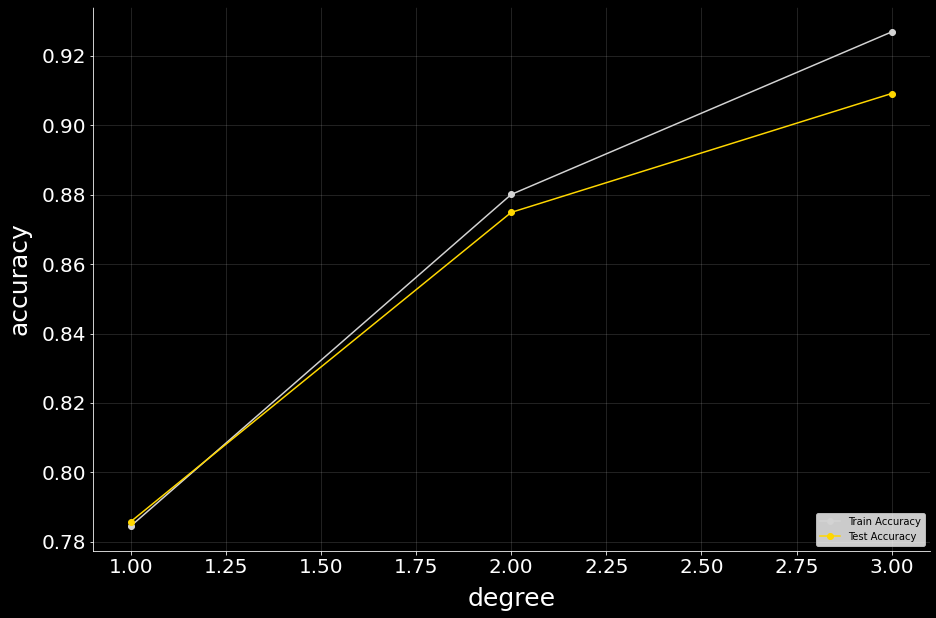

In [ ]:
train_results, test_results = validation_curve_logreg(X_res, y_res, 3)
plot_validation_curve(train_results, test_results, [1,2,3], "validation_curve_logreg_sampled.png", "degree")

## Apply the model with the best parameters and plot ROC curve

In [54]:
def roc_curve_logreg(X, y, degree, name):
    poly = PolynomialFeatures(degree = degree, interaction_only=False, include_bias=False)
        
    X_poly = poly.fit_transform(X)



    kfold = KFold(n_splits=5, random_state=123, shuffle=True)

    fig, ax = plt.subplots(1,1,figsize=(20,10), facecolor="k")
    
    plt.rcParams['axes.facecolor'] = 'k'
   

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,100)
    i = 1
    for train_index, test_index in kfold.split(X_poly, y):

        model = LogisticRegression(solver="newton-cg", n_jobs=-1)

        X_train, X_test = X_poly[train_index], X_poly[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)

        out = model.predict(X_test)

        fpr, tpr, t = roc_curve(y_test, out)

        tprs.append(np.interp(mean_fpr, fpr, tpr))

        roc_auc = auc(fpr, tpr)

        aucs.append(roc_auc)

        ax.plot(fpr, tpr, lw=2, color="w", alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i= i+1

    ax.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'w')
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    ax.plot(mean_fpr, mean_tpr, color='gold',
             label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=4, alpha=1)

    ax.set_xlabel('False Positive Rate',color="w", size=25, labelpad=10)
    ax.set_ylabel('True Positive Rate', color="w", size=25, labelpad=10)
    ax.set_title('ROC')

    ax.text(0.32,0.7,'More accurate area',fontsize = 12)
    ax.text(0.63,0.4,'Less accurate area',fontsize = 12)


    ax.spines['bottom'].set_color('w')
    ax.spines['left'].set_color('w')

    ax.tick_params(axis='x', colors='w')
    ax.tick_params(axis='y', colors='w')

    plt.xticks(size = 20)
    plt.yticks(size = 20)

    ax.grid(color="lightgray", alpha = 0.2)
    ax.legend(loc="lower right", facecolor="w")
    
    plt.savefig("report/"+name, bbox_inches='tight')
    
    return mean_fpr, mean_tpr

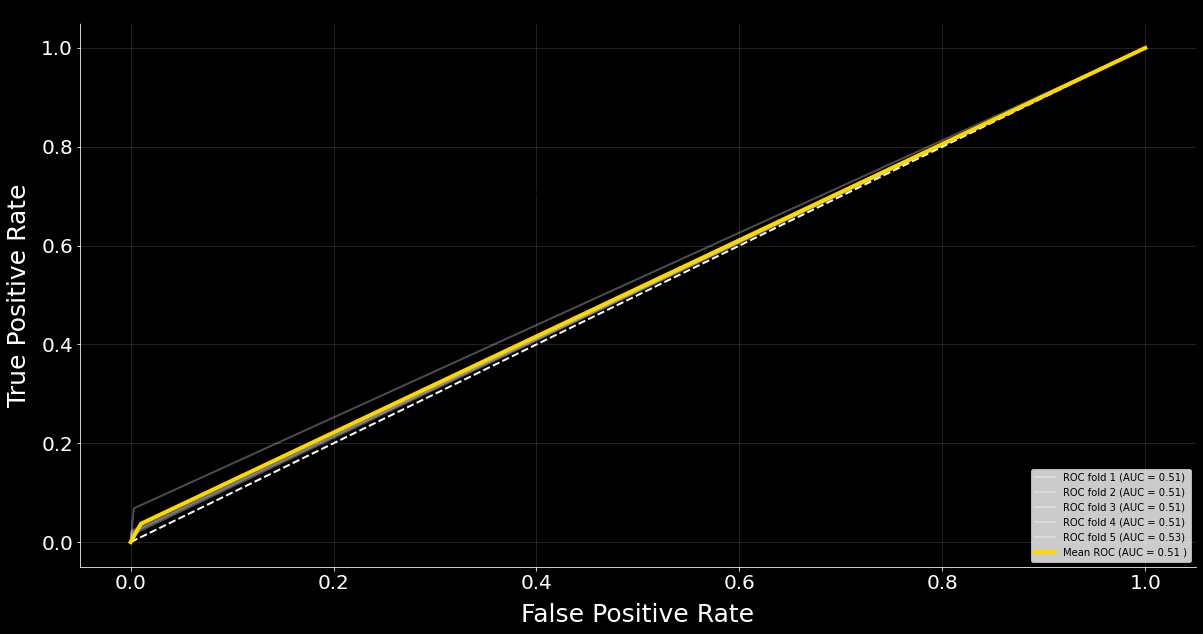

In [76]:
fpr3, tpr3 = roc_curve_logreg(X_big_array, y.array, 2, "roc_curve_log_not_sampled.png")

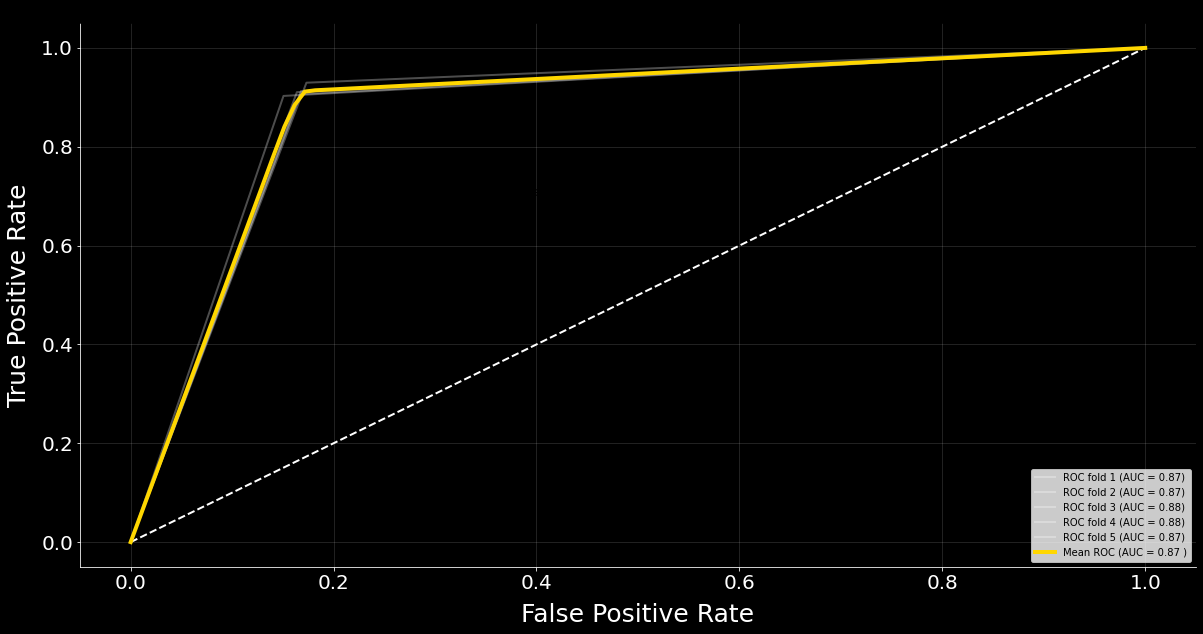

In [77]:
fpr4, tpr4 = roc_curve_logreg(X_res, y_res, 2, "roc_curve_log_sampled.png")

In [ ]:
roc_curve_logreg()

# Feature Selection

In [121]:
skf = StratifiedKFold(n_splits=10, random_state = 123, shuffle=True)
#table = {'n_features': [], 'accuracy score': []}
K_range = range(2,17)

lr = LogisticRegression( solver = 'newton-cg')

sfs = SFS(estimator=lr, 
           k_features=(2, 17),
           forward=True, 
           floating=False, 
           scoring='roc_auc',
           cv=5)

sfs.fit(X_res, y_res)

SequentialFeatureSelector(estimator=LogisticRegression(solver='newton-cg'),
                          k_features=(2, 17), scoring='roc_auc')

best combination (ACC: 0.844): (0, 1, 2, 4, 6, 7, 10, 13, 14)



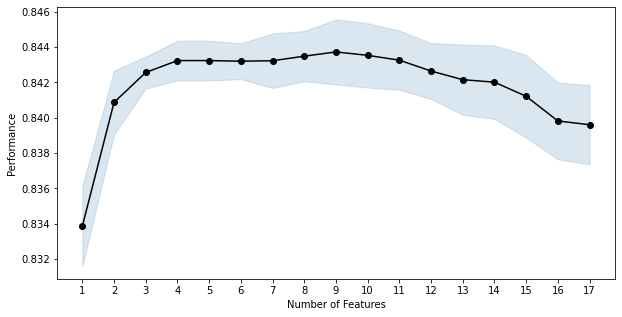

In [120]:
print('best combination (ACC: %.3f): %s\n' % (sfs.k_score_, sfs.k_feature_idx_))
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err', figsize=(10,5), color="k")
plt.savefig("report/feature_select.png", bbox_inches='tight')

best combination (ACC: 0.852): (1, 2, 5, 7, 8, 10, 14, 16)



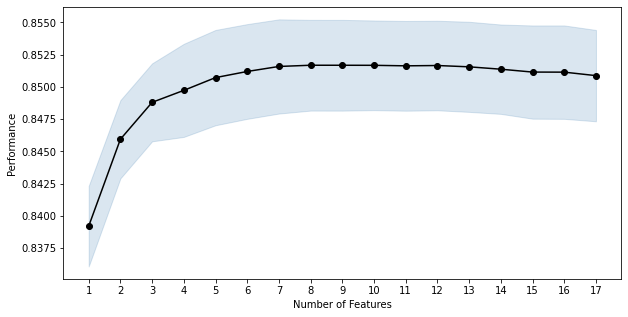

In [122]:
print('best combination (ACC: %.3f): %s\n' % (sfs.k_score_, sfs.k_feature_idx_))
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err', figsize=(10,5), color="k")
plt.savefig("report/feature_select.png", bbox_inches='tight')

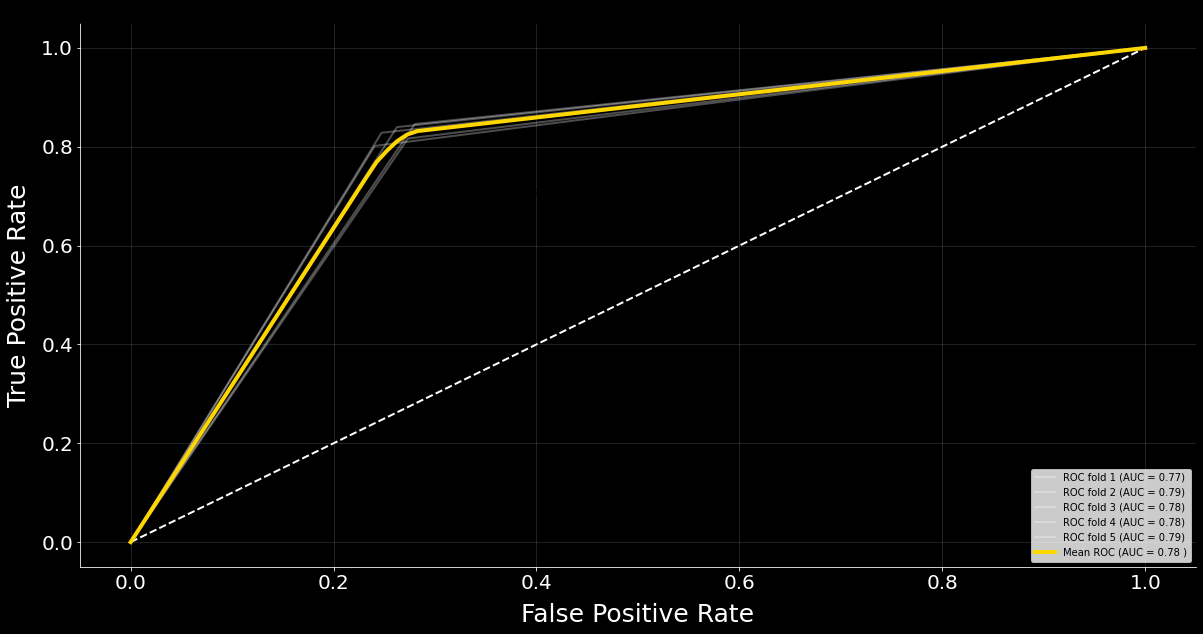

In [126]:
fpr5, tpr5 = roc_curve_logreg(X_res[:,sfs.k_feature_idx_], y_res, 1, "test.png")

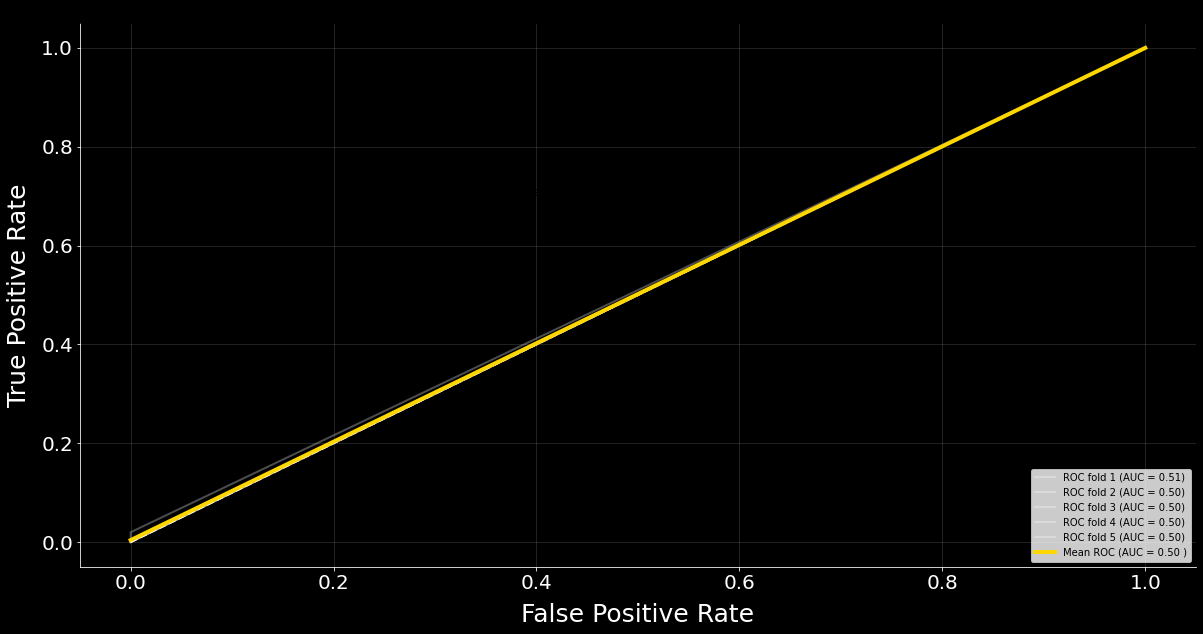

In [116]:
fpr6, tpr6 = roc_curve_logreg(X_big_array[:,sfs.k_feature_idx_], y.array, 1, "test.png")

# ROC Comparison

In [117]:
def roc_total(fpr1, tpr1, fpr2, tpr2, fpr3, tpr3, fpr4, tpr4, fpr5, tpr5, fpr6, tpr6, name):
    
    fig, ax = plt.subplots(1,1,figsize=(20,10), facecolor="k")
    
    plt.rcParams['axes.facecolor'] = 'k'
    
    ax.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'w')
    
    
    ax.plot(fpr1, tpr1, color='gold',
        label=r'Mean ROC KN NOT RES(AUC = %0.2f )' % (auc(fpr1, tpr1)),lw=4, alpha=1)
    
    ax.plot(fpr2, tpr2, color='blue',
        label=r'Mean ROC KN RES(AUC = %0.2f )' % (auc(fpr2, tpr2)),lw=4, alpha=1)

    ax.plot(fpr3, tpr3, color='r',
        label=r'Mean ROC LOGREG NOT RES(AUC = %0.2f )' % (auc(fpr3, tpr3)),lw=4, alpha=1)

    ax.plot(fpr4, tpr4, color='green',
        label=r'Mean ROC LOGREG RES(AUC = %0.2f )' % (auc(fpr4, tpr4)),lw=4, alpha=1)
    
    ax.plot(fpr5, tpr5, color='orchid',
        label=r'Mean ROC LOGREG feature select(AUC = %0.2f )' % (auc(fpr5, tpr5)),lw=4, alpha=1)
    
    ax.plot(fpr6, tpr6, color='purple',
        label=r'Mean ROC LOGREG feature select(AUC = %0.2f )' % (auc(fpr6, tpr6)),lw=4, alpha=1)

    ax.set_xlabel('False Positive Rate',color="w", size=25, labelpad=10)
    ax.set_ylabel('True Positive Rate', color="w", size=25, labelpad=10)
    ax.set_title('ROC')

    ax.text(0.32,0.7,'More accurate area',fontsize = 12)
    ax.text(0.63,0.4,'Less accurate area',fontsize = 12)


    ax.spines['bottom'].set_color('w')
    ax.spines['left'].set_color('w')

    ax.tick_params(axis='x', colors='w')
    ax.tick_params(axis='y', colors='w')

    plt.xticks(size = 20)
    plt.yticks(size = 20)

    ax.grid(color="lightgray", alpha = 0.2)
    ax.legend(loc="lower right", facecolor="w")
    
    plt.savefig("report/"+name, bbox_inches='tight')

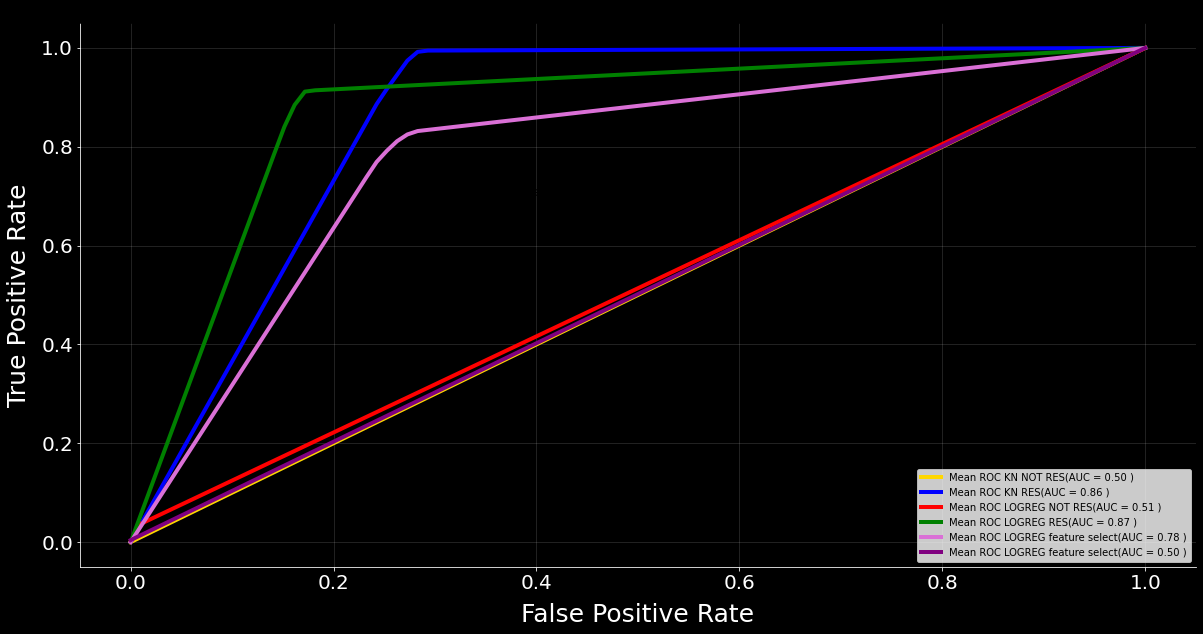

In [118]:
roc_total(fpr1, tpr1, fpr2, tpr2, fpr3, tpr3, fpr4, tpr4, fpr5, tpr5, fpr6, tpr6, "tot_roc.png")

# Future work...

In [ ]:
accuracies = []

for degree in tqdm(range(1,5)):

    c_scores = []

    for c in [0.01,0.1,1,10,100]:

        kfold = KFold(n_splits=10, random_state=123, shuffle=True)

        model = LogisticRegression(solver="newton-cg", n_jobs=-1)

        sfs_kn = sfs(estimator = model, k_features=f, cv=kfold, n_jobs=-1)

        poly = PolynomialFeatures(degree = degree, interaction_only=False, include_bias=False)

        X_res_poly = poly.fit_transform(X_res)

        sfs_kn.fit(X_res_poly, y_res)

        temp_X_res_poly = sfs_kn.transform(X_res)

        scores = cross_val_score(model, temp_X_res_poly, y_res, scoring='accuracy', cv=kfold, n_jobs=-1)

        c_scores.append((np.mean(scores), c, temp_X_res_poly.shape[1]))


    accuracies.append(max(c_scores, key=y=lambda e: e[0])[0], max(c_scores, key=lambda e: e[0])[1])